# 8. Tree Detection and Segmentation

One of the first prevalent tree detection methods was the watershed segmentation method. This method is also used as a subroutine for various other detection methods. pyfor offers functionality for raster based watershed segmentation. This is accomplished by tying a few other packages together.

As always, pyfor allows for interactive tweaking of parameters through `matplotlib` plots.

In [5]:
import pyfor
# Make plot size a bit bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 7]

## Segmentation

Segmentation is the act of defining regions of the canopy height model that are considered crown segments. `pyfor` implements the watershed segmentation algorithm to produce crown segments from canopy height models.

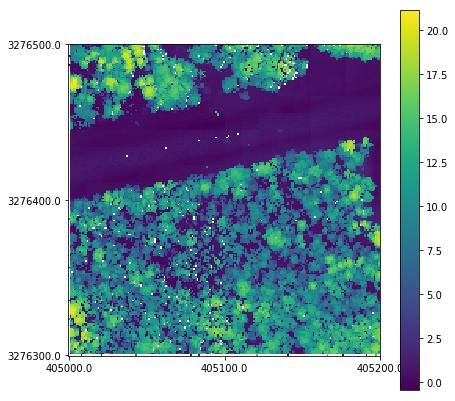

In [6]:
# Load and normalize the point cloud
pc = pyfor.cloud.Cloud("../data/test.las")
pc.normalize(10)
pc.plot()

pyfor's watershed segmentation implementation is based on two subroutines:

`skimage.feature.peak_local_max` and `skimage.morphology.watershed`

The first is used to detect local maxima, more documentation is available [here](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max). The second is used to conduct the watershed segmentation algorithm using the detected peaks as starting locations, its documentation can be found [here](http://scikit-image.org/docs/dev/api/skimage.morphology.html#skimage.morphology.watershed).

First we need to construct a useful canopy height model. We can do this with the `Cloud.chm` method.

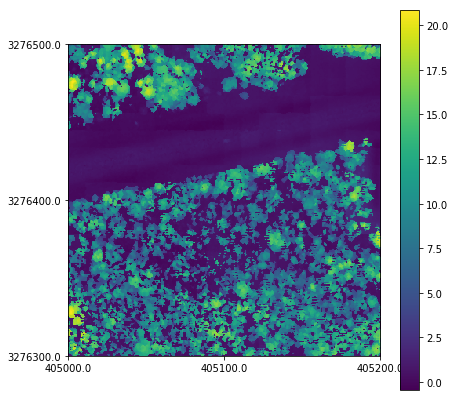

In [7]:
chm = pc.chm(0.5, interp_method = "nearest", pit_filter="median")
chm.plot()

Now we can a `CrownSegments` object, which is essentially a canopy height model with detected crown polygons. We can generate a default watershed segmentation using the following.

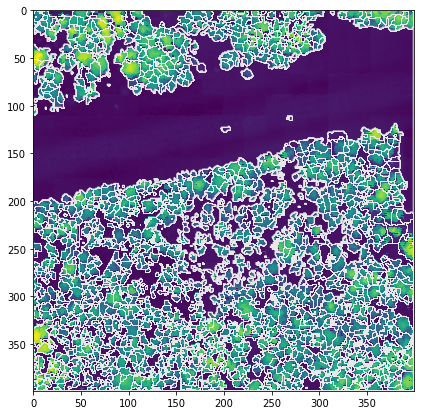

In [13]:
chm.watershed_seg().plot()

Looks like we could tweak things a bit, let's try some different settings.

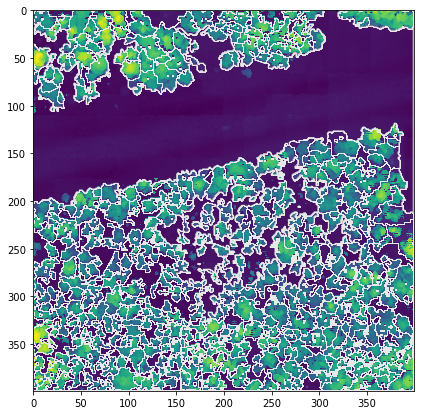

In [16]:
chm.watershed_seg(min_distance=5, threshold_abs=6).plot()

If we are satisfied with the output, we can access the segments of the `CrownSegments` object with the `CrownSegments.segments` attribute. This returns the segments as a `geopandas` `GeoDataFrame`. This has two columns, `geometry` contains the polygon information, and `raster_val` contains the unique ID of each segment. A value of 0 indicates it was underneath our absolute threshold (and thus is not plotted).

In [18]:
segmentation = chm.watershed_seg(min_distance=4, threshold_abs=2)
segmentation.segments.head()

,geometry,raster_val
0,"POLYGON ((0 0, 0 3, 1 3, 1 1, 2 1, 2 0, 0 0))",0.0
1,"POLYGON ((5 0, 5 1, 7 1, 7 3, 8 3, 8 1, 9 1, 9...",0.0
2,"POLYGON ((61 0, 61 1, 64 1, 64 0, 61 0))",0.0
3,"POLYGON ((163 0, 163 1, 164 1, 164 2, 166 2, 1...",0.0
4,"POLYGON ((176 0, 176 1, 178 1, 178 2, 179 2, 1...",0.0


In [36]:
# Retrieve raster values greater than 0, save to shapefile.
final_segments = segmentation.segments[segmentation.segments["raster_val"] > 0]
final_segments.to_file("segments.shp")